In [1]:
import time
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
import matplotlib.pyplot as plt
import GPy
from scipy import spatial
from collections import Counter

%matplotlib inline
data_ctx = mx.cpu()
model_ctx = mx.cpu()
mx.random.seed(1)
output_fig = False

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda2/lib/python2.7/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
def prepare_data(n_train, n_test):

    mnist_train = datasets.FashionMNIST(train=True)
    train_d, train_labels = mnist_train[0:n_train]
    mnist_test = datasets.FashionMNIST(train=False)
    test_d, test_labels = mnist_test[0:n_test]

    d1, d2, d3, d4 = train_d.shape
    train_d1 = train_d.reshape((d1, d2*d3*d4))
    d1, d2, d3, d4 = test_d.shape
    test_d1 = test_d.reshape((d1, d2*d3*d4))

    train_d2 = train_d1.astype(float)/255.0
    test_d2 = test_d1.astype(float)/255.0
        
    train_data = np.zeros((train_d2.shape[0], train_d2.shape[1]), dtype="float32")
    for j in range(0, train_d2.shape[0]):
        if(j%500 == 0):
            print (j)
        new_row = [i.asnumpy() for i in train_d2[j, :]]
        flat_new_row = [item for sublist in new_row for item in sublist]
        train_data[j, :] = flat_new_row 

    test_data = np.zeros((test_d2.shape[0], test_d2.shape[1]), dtype="float32")
    for j in range(0, test_d2.shape[0]):
        if(j%500 == 0):
            print (j)
        new_row = [i.asnumpy() for i in test_d2[j, :]]
        flat_new_row = [item for sublist in new_row for item in sublist]
        test_data[j, :] = flat_new_row 

    return train_data, train_labels, test_data, test_labels

In [3]:
train_data, train_labels, test_data, test_labels = prepare_data(5000, 1000)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
0
500


In [4]:
start =  time.time()

DIM=2
max_iters = 500
m = GPy.models.BayesianGPLVM(train_data, DIM, kernel=GPy.kern.RBF(DIM, ARD=True, useGPU=False))
m.optimize(max_iters = max_iters, messages=True, ipython_notebook=True)

end = time.time()
time_taken = end - start
print (time_taken)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s80  001   3.968611e+06   1.388799e+12 
    09s15  006   1.751744e+06   2.234019e+13 
    13s11  009  -5.301549e+05   2.892807e+10 
    18s41  013  -5.983876e+05   3.091199e+08 
    51s83  038  -6.783052e+05   9.429000e+08 
 02m17s65  104  -8.313873e+05   1.171302e+08 
 06m26s30  291  -9.680830e+05   1.990881e+08 
 09m07s64  410  -1.008118e+06   2.268076e+07 
 09m28s29  425  -1.012025e+06   8.997202e+07 
 09m36s89  431  -1.013084e+06   2.569335e+08 
 09m49s55  440  -1.015481e+06   2.728934e+08 
 10m14s51  459  -1.019618e+06   9.795716e+07 
 10m56s04  489  -1.027546e+06   9.285021e+06 
 11m02s69  494  -1.027781e+06   1.946798e+07 
 11m13s20  502  -1.029420e+06   1.363474e+07 
Runtime:  11m13s20
Optimization status: Maximum number of f evaluations reached

678.706614017


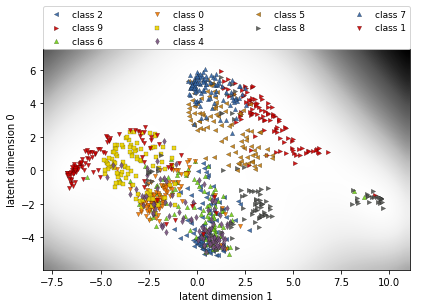

In [42]:
m.plot_latent(labels=train_labels)

In [15]:
#In this cell, the Staionary and RBF classes of GPy are modified.

import GPyOpt
import random 
from scipy import integrate
from GPy.kern.src.kern import Kern
from GPy.core.parameterization import Param
from GPy.util.linalg import tdot
from GPy import util
from GPy.util.config import config
from paramz.caching import Cache_this
from paramz.transformations import Logexp
from GPy.kern.src.stationary import Stationary
from GPyOpt.models import GPModel
from GPyOpt.acquisitions.EI import AcquisitionEI
from sklearn.neighbors import NearestNeighbors
from GPy.kern.src.psi_comp import PSICOMP_RBF, PSICOMP_RBF_GPU
from GPy.kern.src.grid_kerns import GridRBF

class Stationary_Modified(Stationary):
    
    def __init__(self, input_dim, X_variance, variance, lengthscale, ARD, active_dims, name, useGPU=False, dim_reduction_model=None, distance='euclidean'):
        super(Stationary_Modified, self).__init__(input_dim=input_dim, variance=variance, lengthscale=lengthscale, ARD=ARD, active_dims=active_dims, name=name, useGPU=useGPU)
        self.X_variance = X_variance
        self.dim_reduction_model = dim_reduction_model
        self.distance = distance
        
    def _unscaled_dist(self, X, X2=None):
        """
        Compute the Euclidean distance between each row of X and X2, or between
        each pair of rows of X if X2 is None.
        """

        if X2 is None:
            
            if (self.distance == 'euclidean'):
                
                Xsq = np.sum(np.square(X),1)
                r2 = -2.*tdot(X) + (Xsq[:,None] + Xsq[None,:])
                util.diag.view(r2)[:,]= 0. # force diagnoal to be zero: sometime numerically a little negative
                r2 = np.clip(r2, 0, np.inf)
                return np.sqrt(r2)
            
            elif (self.distance == 'geodesic'):
                
                X_1 = np.zeros((X.shape[0] - 1, X.shape[1]))
                X_1[:, :] = X[0, :]
                X_2 = X[1:, :]

                repeats = X.shape[0] - 2

                for i in range(1, X.shape[0]):
                    if (repeats > 0):
                        tmp_1 = np.array([X[i, :],]*repeats)
                        X_1 = np.vstack((X_1, tmp_1))
                        X_2 = np.vstack((X_2, X[(i+1):, :]))
                        repeats -= 1                

                first_term = X_1 - X_2
                third_term = X_1 - X_2
                
                Mi = self.model_bgplvm.predict_wishart_embedding(X_1)
                Mj = self.model_bgplvm.predict_wishart_embedding(X_2)
                second_term = (Mi + Mj) / 2
                
                second_term_reshaped = second_term.reshape(second_term.shape[0], second_term.shape[1]*second_term.shape[2])
                aA = np.multiply(first_term[:, 0], second_term_reshaped[:, 0])
                bC = np.multiply(first_term[:, 1], second_term_reshaped[:, 2])
                aB = np.multiply(first_term[:, 0], second_term_reshaped[:, 1])
                bD = np.multiply(first_term[:, 1], second_term_reshaped[:, 3])
                aAbC = aA + bC
                aBbD = aB + bD
                distances = np.multiply(aAbC, third_term[:, 0]) + np.multiply(aBbD, third_term[:, 1])
                r1 = np.sqrt(distances)

                r2 = np.zeros((X.shape[0], X.shape[0]))    
                j = 0
                for k in range(1, X.shape[0]):
                    for i in range(k, X.shape[0]):
                        r2[k-1, i] = r1[j]
                        r2[i, k-1] = r1[j]                   
                        j += 1 

                return r2
            
            elif (self.distance == 'hellinger'):
                
                X_var = self.X_variance[0:X.shape[0], :]    
                X_1 = np.zeros((X.shape[0] - 1, X.shape[1]))
                X_1[:, :] = X[0, :]
                X_2 = X[1:, :]
                X_variance_1 = np.zeros((X.shape[0] - 1, X.shape[1]))
                X_variance_1[:, :] = X_var[0, :]
                X_variance_2 = X_var[1:, :]

                repeats = X.shape[0] - 2

                for i in range(1, X.shape[0]):
                    if (repeats > 0):
                        tmp_1 = np.array([X[i, :],]*repeats)
                        X_1 = np.vstack((X_1, tmp_1))
                        tmp_1 = np.array([X_var[i, :],]*repeats)
                        X_variance_1 = np.vstack((X_variance_1, tmp_1))

                        X_2 = np.vstack((X_2, X[(i+1):, :]))
                        X_variance_2 = np.vstack((X_variance_2, X_var[(i+1):, :]))                
                        repeats -= 1

                d1 = np.prod(X_variance_1, axis=1) 
                d2 = np.prod(X_variance_2, axis=1) 
                d12 = np.prod(0.5*(X_variance_1+X_variance_2), axis=1) 
                d1p = np.power(d1, 0.25)
                d2p = np.power(d2, 0.25)
                d12p = np.power(d12, 0.5)

                constant = np.divide(np.multiply(d1p, d2p), d12p)

                inv = 1./(0.5*(X_variance_1 + X_variance_2))

                exponent = -0.125 * np.sum(np.multiply(np.multiply((X_1-X_2), inv), (X_1-X_2)), axis=1)

                r1 = np.subtract(np.array([1]), np.multiply(constant, np.exp(exponent)))    #squaredHellingerDistance   

                r2 = np.zeros((X.shape[0], X.shape[0]))    
                j = 0
                for k in range(1, X.shape[0]):
                    for i in range(k, X.shape[0]):
                        r2[k-1, i] = np.sqrt(float(r1[j]))
                        r2[i, k-1] = np.sqrt(float(r1[j]))                   
                        j += 1 

                return r2
            
        else:

            X1sq = np.sum(np.square(X),1)
            X2sq = np.sum(np.square(X2),1)
            r2 = -2.*np.dot(X, X2.T) + (X1sq[:,None] + X2sq[None,:])
            r2 = np.clip(r2, 0, np.inf)
            return np.sqrt(r2)

class RBF_Modified(Stationary_Modified):
    """
    Radial Basis Function kernel, aka squared-exponential, exponentiated quadratic or Gaussian kernel:
    .. math::
       k(r) = \sigma^2 \exp \\bigg(- \\frac{1}{2} r^2 \\bigg)
    """
    _support_GPU = True
    def __init__(self, input_dim, X_variance, variance=1., lengthscale=None, ARD=False, active_dims=None, name='RBF_Modified', useGPU=False, inv_l=False, dim_reduction_model=None, distance='euclidean'):
        super(RBF_Modified, self).__init__(input_dim, X_variance, variance, lengthscale, ARD, active_dims, name, useGPU=useGPU, dim_reduction_model=dim_reduction_model, distance=distance)
        if self.useGPU:
            self.psicomp = PSICOMP_RBF_GPU()
        else:
            self.psicomp = PSICOMP_RBF()
        self.use_invLengthscale = inv_l
        if inv_l:
            self.unlink_parameter(self.lengthscale)
            self.inv_l = Param('inv_lengthscale',1./self.lengthscale**2, Logexp())
            self.link_parameter(self.inv_l)

    def to_dict(self):
        """
        Convert the object into a json serializable dictionary.
        Note: It uses the private method _save_to_input_dict of the parent.
        :return dict: json serializable dictionary containing the needed information to instantiate the object
        """

        input_dict = super(RBF_Modified, self)._save_to_input_dict()
        input_dict["class"] = "GPy.kern.RBF_Modified"
        input_dict["inv_l"] = self.use_invLengthscale
        if input_dict["inv_l"] == True:
            input_dict["lengthscale"] = np.sqrt(1 / float(self.inv_l))
        return input_dict

    def K_of_r(self, r):
        return self.variance * np.exp(-0.5 * r**2)

    def dK_dr(self, r):
        return -r*self.K_of_r(r)

    def dK2_drdr(self, r):
        return (r**2-1)*self.K_of_r(r)

    def dK2_drdr_diag(self):
        return -self.variance # as the diagonal of r is always filled with zeros

    def __getstate__(self):
        dc = super(RBF_Modified, self).__getstate__()
        if self.useGPU:
            dc['psicomp'] = PSICOMP_RBF()
            dc['useGPU'] = False
        return dc

    def __setstate__(self, state):
        self.use_invLengthscale = False
        return super(RBF_Modified, self).__setstate__(state)

    def spectrum(self, omega):
        assert self.input_dim == 1 #TODO: higher dim spectra?
        return self.variance*np.sqrt(2*np.pi)*self.lengthscale*np.exp(-self.lengthscale*2*omega**2/2)

    def parameters_changed(self):
        if self.use_invLengthscale: self.lengthscale[:] = 1./np.sqrt(self.inv_l+1e-200)
        super(RBF_Modified,self).parameters_changed()


    def get_one_dimensional_kernel(self, dim):
        """
        Specially intended for Grid regression.
        """
        oneDkernel = GridRBF(input_dim=1, variance=self.variance.copy(), originalDimensions=dim)
        return oneDkernel

    #---------------------------------------#
    #             PSI statistics            #
    #---------------------------------------#

    def psi0(self, Z, variational_posterior):
        return self.psicomp.psicomputations(self, Z, variational_posterior)[0]

    def psi1(self, Z, variational_posterior):
        return self.psicomp.psicomputations(self, Z, variational_posterior)[1]

    def psi2(self, Z, variational_posterior):
        return self.psicomp.psicomputations(self, Z, variational_posterior, return_psi2_n=False)[2]

    def psi2n(self, Z, variational_posterior):
        return self.psicomp.psicomputations(self, Z, variational_posterior, return_psi2_n=True)[2]

    def update_gradients_expectations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior):
        dL_dvar, dL_dlengscale = self.psicomp.psiDerivativecomputations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior)[:2]
        self.variance.gradient = dL_dvar
        self.lengthscale.gradient = dL_dlengscale
        if self.use_invLengthscale:
            self.inv_l.gradient = dL_dlengscale*(self.lengthscale**3/-2.)

    def gradients_Z_expectations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior):
        return self.psicomp.psiDerivativecomputations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior)[2]

    def gradients_qX_expectations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior):
        return self.psicomp.psiDerivativecomputations(self, dL_dpsi0, dL_dpsi1, dL_dpsi2, Z, variational_posterior)[3:]

    def update_gradients_diag(self, dL_dKdiag, X):
        super(RBF_Modified,self).update_gradients_diag(dL_dKdiag, X)
        if self.use_invLengthscale: self.inv_l.gradient =self.lengthscale.gradient*(self.lengthscale**3/-2.)

    def update_gradients_full(self, dL_dK, X, X2=None):
        super(RBF_Modified,self).update_gradients_full(dL_dK, X, X2)
        if self.use_invLengthscale: self.inv_l.gradient =self.lengthscale.gradient*(self.lengthscale**3/-2.)

In [26]:
class GPUncertainInputs(GPModel):
    """
    General class for handling a Gaussian Process in GPyOpt.

    :param kernel: GPy kernel to use in the GP model.
    :param noise_var: value of the noise variance if known.
    :param exact_feval: whether noiseless evaluations are available. IMPORTANT to make the optimization work well in noiseless scenarios (default, False).
    :param optimizer: optimizer of the model. Check GPy for details.
    :param max_iters: maximum number of iterations used to optimize the parameters of the model.
    :param optimize_restarts: number of restarts in the optimization.
    :param sparse: whether to use a sparse GP (default, False). This is useful when many observations are available.
    :param num_inducing: number of inducing points if a sparse GP is used.
    :param verbose: print out the model messages (default, False).
    :param ARD: whether ARD is used in the kernel (default, False).

    .. Note:: This model does Maximum likelihood estimation of the hyper-parameters.

    """

    analytical_gradient_prediction = True  # --- Needed in all models to check is the gradients of acquisitions are computable.

    def __init__(self, kernel=None, noise_var=None, exact_feval=False, dim_reduction_model=None, distance='euclidean', regression_model_type='GP', optimizer='bfgs', max_iters=1000, optimize_restarts=5, sparse = False, num_inducing = 10,  verbose=False, ARD=False):
        self.kernel = kernel
        self.noise_var = noise_var
        self.exact_feval = exact_feval
        self.dim_reduction_model = dim_reduction_model
        self.distance = distance
        self.regression_model_type = regression_model_type
        self.optimize_restarts = optimize_restarts
        self.optimizer = optimizer
        self.max_iters = max_iters
        self.verbose = verbose
        self.sparse = sparse
        self.num_inducing = num_inducing
        self.model = None
        self.ARD = ARD


    def _create_model(self, X, Y, X_variance):
        """
        Creates the model given some input data X and Y.
        """

        # --- define kernel
        self.input_dim = X.shape[1]

        if self.kernel is None:
            kern = RBF_Modified(input_dim=2, X_variance=X_variance, ARD=True, useGPU=False, dim_reduction_model=self.dim_reduction_model, distance=self.distance)
            
        else:
            kern = self.kernel
            self.kernel = None           
            
        # --- define model
        noise_var = Y.var()*0.01 if self.noise_var is None else self.noise_var
        
        #print (X.shape)
        
        if (self.regression_model_type == "GP"):
            self.model = GPy.models.GPRegression(X, Y, kernel=kern, noise_var=noise_var)
        elif (regression_model_type == "BGPLVM"):
            self.model = GPy.models.BayesianGPLVM(Y, self.input_dim, X, X_variance, kernel=kern)
        else:
            print ("Regression model can either be GP or BGPLVM.")                                
            
        # --- restrict variance if exact evaluations of the objective
        if self.exact_feval:
            self.model.Gaussian_noise.variance.constrain_fixed(1e-5, warning=False)
        else:
            # --- We make sure we do not get ridiculously small residual noise variance
            self.model.Gaussian_noise.variance.constrain_bounded(1e-9, 1e6, warning=False) #constrain_positive(warning=False)

    def updateModel(self, X_all, Y_all, X_variance_all):
        """
        Updates the model with new observations.
        """
        self._create_model(X_all, Y_all, X_variance_all)

        # WARNING: Even if self.max_iters=0, the hyperparameters are bit modified...
        if self.max_iters > 0:
            # --- update the model maximizing the marginal likelihood.
            if self.optimize_restarts==1:
                self.model.optimize(optimizer=self.optimizer, max_iters = self.max_iters, messages=False, ipython_notebook=False)
            else:
                self.model.optimize_restarts(num_restarts=self.optimize_restarts, optimizer=self.optimizer, max_iters = self.max_iters, verbose=self.verbose, messages=False)

In [27]:
class LVBO(object):
    
    def __init__(self, f, domain, X, Y, X_var, dim_reduction_model=None, distance='euclidean', regression_model_type='GP', exact_feval = False, normalize_Y = False, **kwargs):
    
        ### Initialize objects
        self.f = f
        self.space = GPyOpt.Design_space(domain)
        self.aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(self.space)
        self.dim_reduction_model = dim_reduction_model   
        self.distance = distance
        self.regression_model_type = regression_model_type
        self.model = GPUncertainInputs(exact_feval=exact_feval, dim_reduction_model=dim_reduction_model, distance=distance)
        self.normalize_Y = normalize_Y
        
        ### Initilize data
        self.X = X
        self.X_var = X_var
        self.Y = Y
        
    def run_optimization(self,max_iter):
        
        current_iter = 0
        while current_iter < max_iter: 
    
            if self.normalize_Y and (self.Y.shape[0]>1) and (self.Y.std()>0):
                Y_inmodel = (self.Y-self.Y.mean())/(self.Y.std())
            else:
                Y_inmodel = self.Y.copy()
    
            ## --- create model
            self.model.updateModel(self.X, Y_inmodel, self.X_var)

            ## --- create acquisition
            self.acquisition = AcquisitionEI(self.model, self.space, self.aquisition_optimizer)

            ## --- compute next location
            X_next, _ = self.acquisition.optimize()

            ## --- Compute input variance

            # --- Variance of the inputs
            if self.dim_reduction_model is None:
                
                print ("Dim_reduction_model cannot be None.")
                
            else:               
                
                mu, var = self.dim_reduction_model.predict(X_next, full_cov=True)
                _, model = self.dim_reduction_model.infer_newX(mu)  
                X_next_mean = model.latent_space.mean
                X_next_var = model.latent_space.variance
            
                   
            ## --- Evaluate objective
            Y_next = self.f(X_next)

            ## --- Update matrices            
            self.X     = np.vstack((self.X, X_next_mean))
            self.X_var = np.vstack((self.X_var, X_next_var))            
            self.Y     = np.vstack((self.Y, Y_next))

            current_iter += 1

In [30]:
def best_latent_representations(test_data, n, latent_training_mean, latent_training_var, dim_reduction_model, regression_model_type, init_type, latent_distance, iterations):

    DIM = 2
    best_latents = np.zeros((n, DIM))

    for k in range(0, n):
        
        print ("Test point: ", k)
        
        y_ref = test_data[k, :]
        
        def objective_func(latent_space_datapoints):
            distances = np.zeros((latent_space_datapoints.shape[0], 1))
            for kk in range(0, latent_space_datapoints.shape[0]):
                latent_space_datapoint = np.zeros((1, DIM))
                latent_space_datapoint[0, :] = latent_space_datapoints[kk, :]
               
                mu, var = dim_reduction_model.predict(latent_space_datapoint)
                _, model = dim_reduction_model.infer_newX(mu)  
                mu_inferred = model.latent_space.mean             
                y_mu, y_var = dim_reduction_model.predict(mu_inferred)
                                
                distance = np.sum((y_mu-y_ref)**2)
                distances[kk, 0] = distance
            return distances
        
        domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (-7,7)},
                  {'name': 'var_2', 'type': 'continuous', 'domain': (-7,7)}]
        space = GPyOpt.Design_space(domain)
        
        n_samples = 5
        
        
        initial_design = np.zeros((n_samples, DIM))
        X_var = np.zeros((n_samples, DIM))
        
        if (init_type == "random"):
            for jj in range(0, n_samples):
                index = random.randint(0, 5000)
                initial_design[jj, :] = latent_training_mean[index, :] 
                X_var[jj, :] = latent_training_var[index, :]    
        elif(init_type == "training"):      
            initial_design = (np.random.rand(n_samples, DIM) - 0.5) * 14
            X_var = np.zeros((n_samples, DIM))
            for jj in range(0, n_samples):
                mu, var = dim_reduction_model.predict(initial_design[jj, :].reshape(1, 2))
                _, model = dim_reduction_model.infer_newX(mu)  
                var = model.latent_space.variance  
                X_var[jj, :] = var        
        
        Y = objective_func(initial_design)         
        
        BO = LVBO(objective_func, domain, initial_design, Y, X_var, dim_reduction_model, latent_distance, regression_model_type, exact_feval = True, normalize_Y = True)
                
        BO.run_optimization(iterations)
        
        best_latents[k, :] = BO.X[np.argmin(BO.Y),:]
        print ("Optimum latent space point: ", best_latents[k, :])
        
    return best_latents

In [31]:
latent_training_mean = m.latent_space.mean
latent_training_var = m.latent_space.variance
num_test_images = 1
dim_reduction_model = m
regression_model_type = "BGPLVM"  #Alternative choice is "GP"
init_type = "training"  #Alternative choice is "random"
latent_distance = "hellinger"#Alternative choices are "euclidean" or "geodesic"
iterations = 25

start = time.time()
bl = best_latent_representations(test_data, num_test_images, latent_training_mean, latent_training_var, dim_reduction_model, regression_model_type, init_type, latent_distance, iterations)
time_elapsed = time.time() - start

print ("Time taken: ", time_elapsed)

('Test point: ', 0)
('Optimum latent space point: ', array([-1.59873254, -2.70685502]))
('Time taken: ', 21.359410047531128)


Test image:


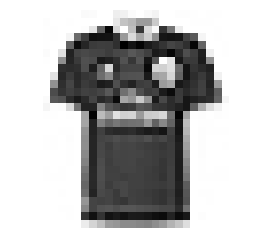

Closest image:


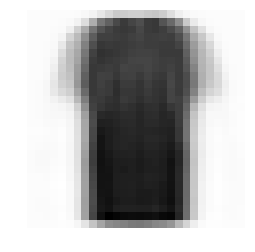

In [45]:
closest_matches, var = m.predict(bl)
A = []
for i in range(0, num_test_images):
    distance = np.sum((closest_matches[i, :]-test_data[i, :])**2)
    A.append(distance)
    
    plt.hold(True)
    
    print ("Test image:")
    plt.imshow(test_data[i, :].reshape((28,28)), cmap='Greys', hold="True")
    plt.axis('off')
    plt.show()
    
    print ("Closest image:")
    plt.imshow(closest_matches[i, :].reshape((28,28)), cmap='Greys')
    plt.axis('off') 
    plt.show()